In [ ]:
!pip install cartopy
!pip install argovisHelpers

In [ ]:
# %load_ext autoreload
# %autoreload 2

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import seaborn as sns
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from cdomHelpers import *

sns.set_style("darkgrid")

API_KEY='3e2bda40368d095888a54898b2f52c1fa50df102'
API_PREFIX = 'https://argovis-api.colorado.edu/'
API_KEY='3e2bda40368d095888a54898b2f52c1fa50df102'
API_PREFIX = 'https://argovis-api.colorado.edu/'

### Argo CDOM Observations
- CDOM profiles in show distinct values at depths > 1000 m, even in the same region of the ocean
- This occurs for both ECO and MCOMS sensors
- Evidence points to issues with calibration standards used for both ECO and MCOMS, rather than secondary reference sensor drift or random changes in in-situ dark count drift

In [ ]:
dataSetName= 'JAMSTEC NAVIS_A'
(dfm, dfmap) = dfRead(dataSetName)
plotdfmByYear(dataSetName, dfm, 'cdom', xrange=[0,10])
dfm.head(2) 

### MCOMS secondary reference sensor calibration history
- For each calibration period, secondary reference sensor calibration (RefScaleFactor) is considered constant 
- This is contrary to initial assumption but consistent with distinct "stripes" in CDOM data

In [ ]:
dfref = pd.read_csv('MCOMS-036-Calibration-SF-CF.csv')
dfref.head(10)

### Developement of CDOM Reference Sensor Correction

First, the Scaling Factor SF due to change in CDOM primary reference preparation was found by taking ratio of mean scale factors for three secondary reference CDOM sensors (two ECO, one MCOMS) over short period just prior and after the change in primary reference,  taking the mean of these three ratios, yielding SF = 5.62.  
```
    ScalingFactor = SF = 5.62  (calDate <  2013-01-13)
                       = 1.00  (calDate >= 2013-01-13)
```
Then we can scale any reference factor atonew CDOM primary:
```
    RefScaleFactorScaled = RefScaleFactor * SF
```

Next, the correction factor CF is computed by normalizing the RefScaleFactorAdj to mean RefScaleFactorAdj for calibraitons after the primary CDOM reference was updated (SF=1):
```
    CF = mean(RefScaleFactorAdj[SF=1])/ RefScaleFactor
```

Any CDOM ScaleFactor is found by:

```
    ScaleFactorCorrected = ScaleFactor * SF * CF
    RefScaleFactorCorrected = RefScaleFactor * SF * CF
```

In [ ]:
# RefScaleFactors vs. time
cols = ['RefScaleFactor', 'RefScaleFactorScaled', 'RefScaleFactorCorrected']
df2 = dfref.melt(id_vars='RefCalDate', value_vars = cols)
fig = px.scatter(df2, x="RefCalDate", y="value", title='Reference Scale Factors', color='variable', symbol='variable', range_y=[0,0.04], height=400, width=800)
fig.update_traces(marker_size=8)
fig.show()


### In Situ Validity Check: 
* Select data from NW Pacific (JAMSETC floats)
* Scale MCOMS CDOM data by SF.  
* Compute CDOM2000 = mean(CDOM) at approx. 2000 m for each float across all profiles/
* CDOM2000ref = CDOM2000[SF=1] (one float with correct CDOM a calibration (>= 2023-01-13)
* For remaining floats: Within each calibration period i, find mean(CDOM2000(i)
* Compute DeepCF(i) = CDOM2000ref / CDOM2000(i)
* DeepCF should be close to CF (possible addtional in situ variability)

In [ ]:
# Correction Factor vs. time  
cols = ['CF', 'DeepCF']
df3 = dfref.melt(id_vars='RefCalDate', value_vars = cols)
fig = px.scatter(df3, x="RefCalDate", y="value", title='Correction Factor Validation', color='variable', symbol='variable', range_y=[0,1.1], height=400, width=800)
fig.update_traces(marker_size=8)
fig.show()

### CDOM Correction database corrCDOM
- __SBS__:  SF*CF correction applied to ScaleFactor for *every* SBS MCOMS sensor for which we have calibration data (N=267)
- __Argo__: Metadata (C. Schmechtig) for all Argo CDOM sensors for each DAC: (wmoid, SENSOR_MODEL, SENSOR_SERIAL_NO,...) 
- __SBS__ ⟕ __Argo__ : SBS and Argo tables joined using SENSOR_SERIAL_NO (M = 137)
- M < N due to prototypes, R&D deployments, failed sensors, etc.
- CDOMcorr DB has unique entry for each WMOID-SENSOR_SERIAL_NUMBER combination

Corrections can applied to existing data by simple WMOID lookup:  
```
    SF = corrCDOM.query(wmoid, 'SF')
    CF = corrCDOM.query(wmoid, 'CF')
    CDOM' = CDOM * SF * CF
```

In [ ]:
CDOMcorr().gist()

### Step 1: Find set of floats that span the range of MCOMS calibration dates in the same region of the ocean

 --> Argovis spatial query using polygon
 --> Cannot do Argovis query by SENSOR_MODEL but can do query by PLATFORM_TYPE (effectively limiting query to MCOMS)

In [ ]:
# !!!!!!!!!!!!!

dataSetName = 'JAMSTEC'
polygon = '[[141,54.5],[141, 26.3],[179.9, 26.3],[179.9, 54.5],[141, 54.5]]'
startDate = '2017-01-01T00:00:00Z'
endDate = ''

# Cannot do Argovis query by SENSOR_MODEL but can do by PLATFORM_TYPE (effectively limiting query to MCOMS)
platform_type = 'NAVIS_A'   #'NAVIS_A', 'NAVIS_EBR', 'PROVOR_III', etc.

# Setup region-date query
# Note that '2012-10-13T00:00:00Z' is earliest startDate for BGC Argo data
# avh.query will crash if you supply a date earlier than that.
# Also note all data can be retrieved by changing 'cdom' to 'all'
params = {
        'startDate': startDate,
        'endDate':   endDate,
        'source': 'argo_bgc',
        'polygon': eval(polygon),
        'data': 'cdom,temperature,salinity',
        'platform_type' : platform_type
    }  

dataSetName = dataSetName + ' ' + platform_type
print(dataSetName)
print(params)

### Found: JAMSTEC NAVIS_A Floats in NW Pacific spanning 2018-2024
This period spans :
*  SF : Transition to correct CDOM Primary Reference (CDOM Advisory Issue #1) - Applies only to calibrations prior to 2023-01-13.
*  CF : Six correction factors representing six Reference sensor calibration dates (CDOM Advisor Issue #2),

In [ ]:
# Retrieve CDOM Profile data using spatial query 
(dfm, dfmap) = getProfilesFromPolygon(polygon, startDate, endDate, platform_type)
dfm.head()
dfSave(dataSetName, dfm,dfmap)

In [ ]:
dfm, dfmap = dfRead(dataSetName)
mapboxProfiles(dfmap, dataSetName, polygon)

### Step 2: Regional Validation : NAVIS_A fDOM NWPacific Set  (reduced set selected from geoquery above)

Answer two questions:
1. Do the CDOM profiles align reasonably using SF*CF correction?
2. Independently derive DeepCF from alignment of deep (2000 m), using a single recently deploye NAVIS float (5906597) as reference

```platforms = [2903213,2903329,2903393,2903396,2903666,2903669,2903700,5906596,5906597]```

In [ ]:
# Retrieve data using a list of floats (WMOids)

# Setup CDOM correction database
cdomCorr = CDOMcorr()

# Define data set
dataSetName = 'NAVIS_A fDOM NWPacific Set'
platforms = np.array([2903213,2903329,2903393,2903396,2903666,2903669,2903700,5906596,5906597])

# Look up scale factor from CDOMcorr DB
doCorrection = True
ScalingFactor = [ cdomCorr.query(wmoid, 'SF') for wmoid in platforms]
CorrectionFactor = [ cdomCorr.query(wmoid, 'CF') for wmoid in platforms]
# CorrectionFactor = np.array([0.40,0.40,0.40,0.40,0.40,0.40, 0.93,0.93,1.00])   #derived from Deep CDOM

print(f'CF = {CorrectionFactor}')
print(f'SF = {ScalingFactor}')

# define temporal query parameters
startDate = '2017-01-01T00:00:00Z'
endDate = ''

# Uncomment to run argovis query
# (dfm, dfmap) = getProfilesFromFloats(platforms, startDate, endDate, doCorrection, CorrectionFactor, ScalingFactor)
# dfSave(dataSetName, dfm, dfmap)

In [ ]:
dfm, dfmap = dfRead(dataSetName)
cdom2000(dfm)

mapboxProfiles(dfmap, dataSetName)

In [ ]:
# Plot: color by wmoid, facet by year, animate by cdom variable 
(dfm, dfmap) = dfRead(dataSetName)
plotdfmByYearAnim(dataSetName, dfm)

### Step 3: Global Validation : NAVIS_A fDOM Global Validation Set  

Select 28 floats worldwide to span as much of the MCOMS calibration history as possible

Answer two questions:
1. Is the MCOMS SF*CF correction valid globally?
2. Is the variability in the results consistent with what we know about global CDOM Hydrography?  (c.f., Nelson et al., 2010)

--> Expectation for #1: It should be, as the correction was derived from MCOMS secondary reference sensor calibration history, *not* in situ data.

```
platforms = [5906035,5906036,5906309,5906304,5906306,5906308,1902303,5906305,5906311,5906310,5906026,5906508,5906442,5906307,
             5906563,5906565,5906537,4903500,4903499,5906539,5906540,7901009,2903459,2903462,2903461,2903463,1902497,1902499]
```

In [ ]:
### NAVIS_A fDOM Global Validation Set
# Instead of using polygon, retrieve data using a list of floats (WMOids)
#
# Note that none of mapping routines above work since they all require a polygon.

dataSetName = 'NAVIS_A fDOM Global Validation Set'
platforms = np.array([5906035,5906036,5906309,5906304,5906306,5906308,1902303,5906305,5906311,5906310,5906026,5906508,5906442,5906307,5906563,5906565,5906537,4903500,4903499,5906539,5906540,7901009,2903459,2903462,2903461,2903463,1902497,1902499])
startDate = '2017-01-01T00:00:00Z'
endDate = ''

# Look up scale factor from CDOMcorr DB
doCorrection = True
cdomCorr = CDOMcorr()
ScalingFactor = [ cdomCorr.query(wmoid, 'SF') for wmoid in platforms]
CorrectionFactor = [ cdomCorr.query(wmoid, 'CF') for wmoid in platforms]

print(f'CF = {CorrectionFactor}')
print(f'SF = {ScalingFactor}')

In [ ]:
# Use arovis to get data for a list of floats
(dfm, dfmap) = getProfilesFromFloats(platforms, startDate, endDate, doCorrection, CorrectionFactor, ScalingFactor)
dfSave(dataSetName, dfm, dfmap)

In [ ]:
# Plot: color by wmoid, facet by year, animate by cdom variable 
(dfm, dfmap) = dfRead(dataSetName)
cdom2000(dfm)

mapboxProfiles(dfmap, dataSetName)

plotdfmByYearAnim(dataSetName, dfm)

var = 'temperature'
# (dfm, dfmap) = dfRead(dataSetName)
plotdfmXYByYear(dataSetName, dfm, 'salinity', var)

### Simple statistics of Corrected CDOM @ 2000 m  (mean, std, CoV)

In [ ]:
# Variabiity of Corrected CDOM @ 2000 m

dataSetName = 'NAVIS_A fDOM NWPacific Set'
(dfm, dfmap) = dfRead(dataSetName)
cdom2000(dfm)
print('')


dataSetName = 'NAVIS_A fDOM Global Validation Set'
(dfm, dfmap) = dfRead(dataSetName)
cdom2000(dfm)
print('')

dataSetName = 'NAVIS_A KenJ-20240422'
(dfm, dfmap) = dfRead(dataSetName)
cdom2000(dfm)


dataSetName = 'NAVIS_A fDOM NWPacific Set'
dataSetName = 'NAVIS_A fDOM Global Validation Set'

(dfm, dfmap) = dfRead(dataSetName)
fig = px.box(dfm, x='year', y='cdom_adj', title=dataSetName)
fig.show()
fig.update_yaxes(range=[0,20])
fig.show()
fig = px.violin(dfm, x='year', y='cdom_adj', title=dataSetName)
fig.update_yaxes(range=[0,20])
fig.show()



### Global CDOM Hydrography  (absorption, spectral slope)
 
Nelson et al., GRL, 2010
Tracing global biogeochemical cycles and meridional overturning
circulation using chromophoric dissolved organic matter

https://doi.org/10.1029/2009GL042325

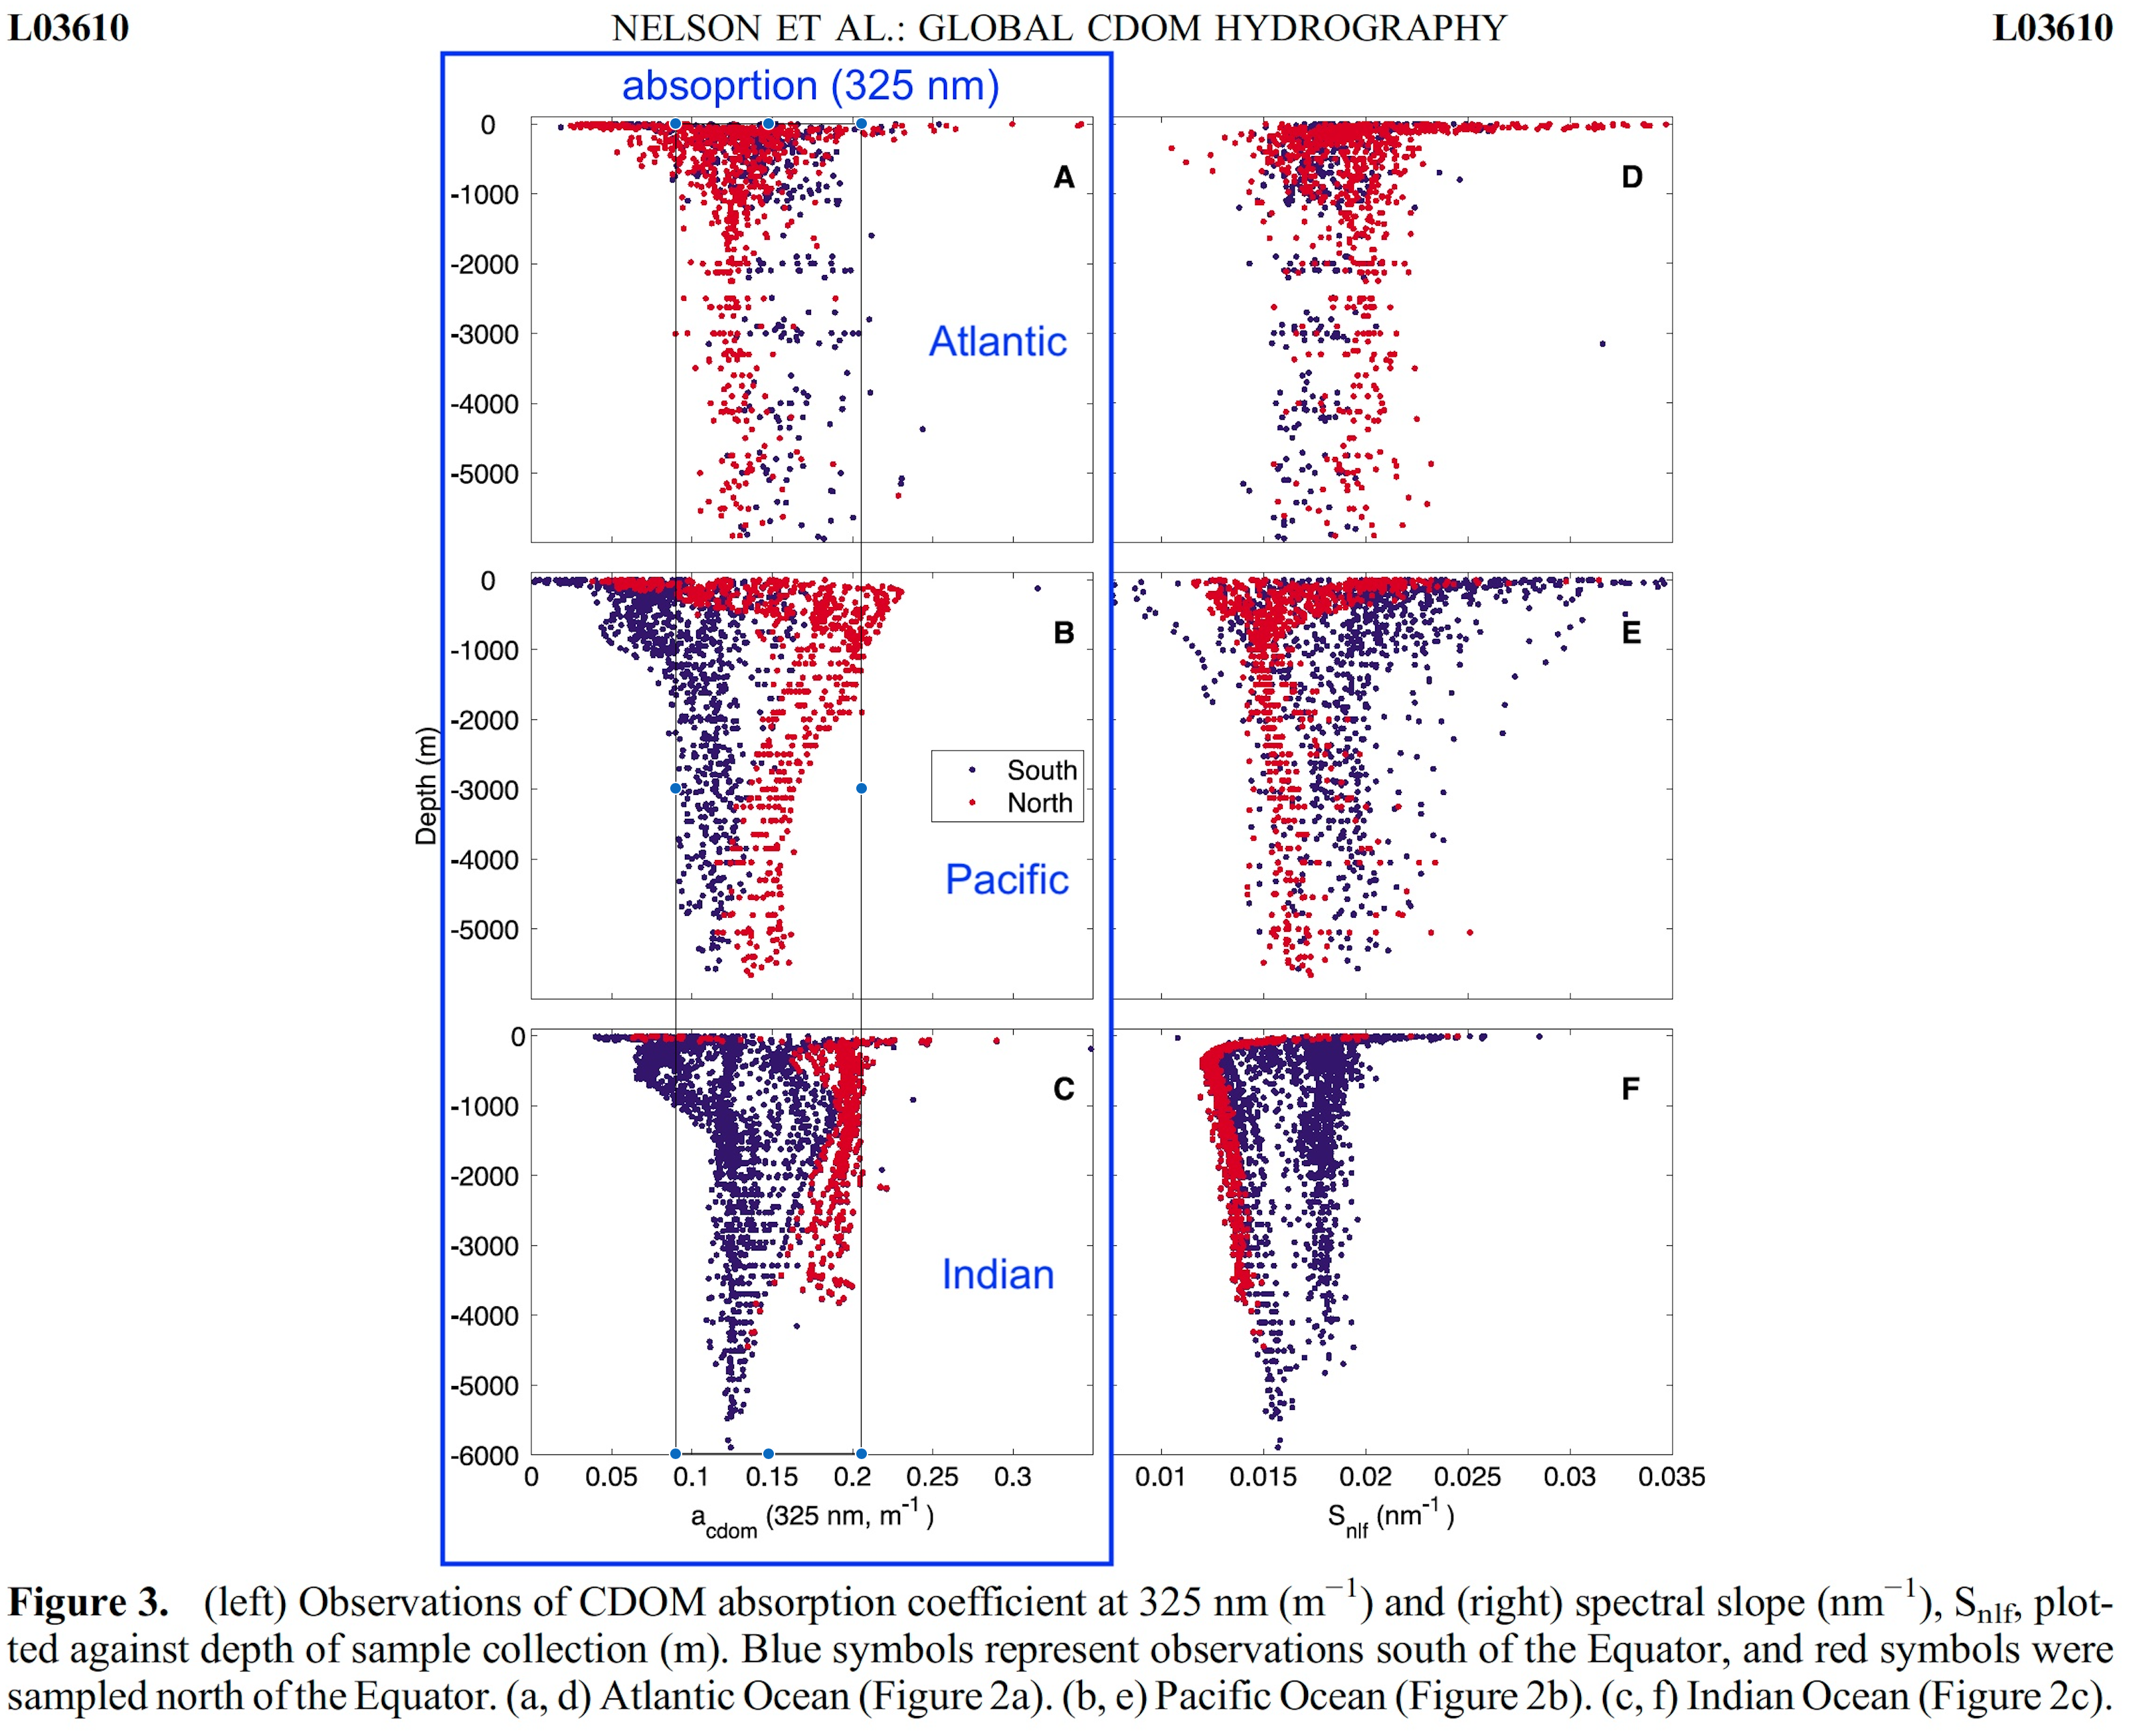

### Check: Recent NAVIS_A Floats, aka KenJ-20240422

platforms = [1902493, 192494, 1902495, 2903863, 2903866, 4903571, 4903752, 7901102]

In [ ]:
dataSetName = 'NAVIS_A KenJ-20240422'
platforms = np.array([1902493, 192494, 1902495, 2903863, 2903866, 4903571, 4903752, 7901102])

# startDate = '2024-01-01T00:00:00Z'
startDate = '2023-01-01T00:00:00Z'
endDate = ''
doCorrection = True
CorrectionFactor = np.array([1,1,1,1,1,1,1,1])
ScalingFactor    = np.array([1,1,1,1,1,1,1,1])

print(f'CF = {CorrectionFactor}')
print(f'SF = {ScalingFactor}')

In [ ]:
(dfm, dfmap) = getProfilesFromFloats(platforms, startDate, endDate, doCorrection, CorrectionFactor, ScalingFactor)
dfSave(dataSetName, dfm, dfmap)

In [ ]:
dfm, dfmap = dfRead(dataSetName)
mapboxProfiles(dfmap, dataSetName)

In [ ]:
# Plot: color by wmoid, facet by year, animate by cdom variable 
(dfm, dfmap) = dfRead(dataSetName)
plotdfmByYear(dataSetName, dfm, 'cdom_adj')

var = 'temperature'
plotdfmXYByYear(dataSetName, dfm, 'salinity', var)

### Extra code

In [ ]:
# dataSetName = 'JAMSTEC NAVIS_A'
dataSetName = 'NAVIS_A fDOM NWPacific Set'
# dataSetName = 'NAVIS_A fDOM Global Validation Set'
# dataSetName = 'PacificNW APEX'
# dataSetName = 'NAVIS_A KenJ-20240422'
 
# Plot it
(dfm, dfmap) = dfRead(dataSetName)
plotdfmByYear(dataSetName, dfm, 'cdom')
plotdfmByYear(dataSetName, dfm, 'cdom_sc')
plotdfmByYear(dataSetName, dfm, 'cdom_adj')

In [ ]:
# Plot: color by wmoid, facet by year, animate by cdom variable 
plotdfmByYearAnim(dataSetName, dfm)

In [ ]:
# Plot it
# var = 'cdom'
# var = 'cdom_sc'
# var = 'cdom_adj'
var = 'temperature'
# (dfm, dfmap) = dfRead(dataSetName)
plotdfmXYByYear(dataSetName, dfm, 'salinity', var)